In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (10, 8)
from keras import optimizers
import tensorflow
from keras.optimizers import adam_v2, nadam_v2
from keras.layers import Dense, LSTM, Flatten, Activation, Conv1D, MaxPooling1D
from keras.models import Model, Sequential
from keras.metrics import RootMeanSquaredError
from keras.engine.input_layer import Input
#from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")
import datetime


In [2]:
import os 
import sys
from google.colab import drive
drive.mount('/content/drive')
#!mkdir "/content/drive/My Drive/NAS_Dissertacao/NAS_Vinicius"
%cd "/content/drive/My Drive/NAS_Dissertacao/NAS_Vinicius"
!pwd
!ls


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/NAS_Dissertacao/NAS_Vinicius
/content/drive/My Drive/NAS_Dissertacao/NAS_Vinicius
 Autokeras_NAS_Dissertacao.ipynb   model.png
 auto_model			   NAS_AK_Dissertacao
'Cópia de NAS_Dissertacao.ipynb'   NAS_Dissertacao.ipynb
 dados_artigo_2019.xlsx		   NAS_Dissertacao.py
'dados_artigo_2 - cópia.xlsx'	   structured_data_regressor
 df_results_NAS_AK_MLP_2019.xlsx   Teste_de_capabilidade.ipynb
 df_results_NEAT_RNN.xlsx	   time_series_forecaster


In [3]:

class NAS:
    ''' Exploracão de Arquitectura de redes neurais utilizando o conceito
    de Neural Architeture Search - NAS https://www.jmlr.org/papers/volume20/18-598/18-598.pdf '''
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.optimizers = ['SGD', 'RMSprop', 'Adam','Adadelta','Adamax']
        self.qtde_camada = [10, 20, 30, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]
        self.tamanho_camada = [32, 64, 128, 256, 512]
        # self.loss = ['mse','mae','map'] # Vou optar por loss = MSE
        self.activation = ['identity', 'logistic', 'relu', 'tanh'] #,'softmax',]
        # self.metricas = ['rmse','mse','mae'] # Vou setar a métrica do algoritmo igual a do artigo

        # Exclusivos Para o modelo MLP Regressor sklearn
        self.hidden_layer = [10, 20, 30, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
        self.alpha = [0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]
        self.batch_size = [50, 100, 150, 200, 250, 300]
        self.learning_rate = [0.1, 0.001, 0.0001, 0.00001, 0.000001, 0.000001]
        self.max_iter = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

    def normaliza_reduz_treino_teste(self):
        '''
        Normalização - Processo no qual da amostra(x) é descontada a média(u) e
        dividido pelo desvio padrão(s), de uma forma que a nova amostra(z) esteja
        em um intervalo de 0 a 1.
        Análise de Componentes Principais - Técnica de estatística multivariada que
        transforma o conjunto de variáveis em
        um subconjunto de variáveis, mantendo as dimensões do original, esse subconjunto
        são os componentes principais. Cada componente é uma combinação linear das variáveis,
        mantendo independência entre si e estimados com o objetivo de reter o máximo de
        informação, em relação a variação contida no conjunto original \citep{Hongyu2016}.
        :df: DataFrame a ser reduzido
        :return: Base completa transformada pelo PCA e normalizada
        '''
        pca = PCA(0.98)
        scaler = StandardScaler()
        self.X_normalizado_reduzido = pd.DataFrame(pca.fit_transform(scaler.fit_transform(self.X)))
        # Base de treino e teste
        self.X_train, self.X_test, \
        self.y_train, self.y_test = train_test_split(self.X_normalizado_reduzido,
                                                     self.y,
                                                    random_state=42)
        return self

    def search_space_keras(self, qtde_arquiteturas):
        ''' Defines which architectures can be represented in principle
        qtde_arquiteturas: Número de Arquiteturas a serem exploradas
        return: Uma lista de parametros a serem utilizados para construção de Redes Neurais'''
        self.activation = ['sigmoid', 'relu', 'selu','elu' ,'tanh',
                           'softmax', 'softplus', 'softsign', 'exponential']
        topografias = []
        for _ in range(qtde_arquiteturas):
            parametro = []
            # Quantidade de camadas
            qtde_camadas = np.random.choice(self.qtde_camada)
            parametro.append(qtde_camadas)
            for _ in range(qtde_camadas):
                # Tamanho de cada camada
                parametro.append(np.random.choice(self.tamanho_camada))
            # # Loss Function
            # parametro.append(np.random.choice(self.loss))
            # Activation Function
            parametro.append(np.random.choice(self.activation))
            # # Métrica de Avaliacao
            # parametro.append(np.random.choice(self.metricas))
            # Otimizador
            parametro.append(np.random.choice(self.optimizers))
            topografias.append(parametro)
        return topografias

    def search_space_sklearn(self, qtde_arquiteturas):
        ''' Defines which architectures can be represented in principle
        qtde_arquiteturas: Número de Arquiteturas a serem exploradas
        return: Uma lista de parametros a serem utilizados para construção de Redes Neurais'''
        topografias = []
        for _ in range(qtde_arquiteturas):
            parametro = []
            # Quantidade de camadas ocultas
            parametro.append(np.random.choice(self.hidden_layer))
            # Função de ativação utilizada
            parametro.append(np.random.choice(self.activation))
            # Termo de regularização L2 - Alpha
            parametro.append(np.random.choice(self.alpha))
            # Tamanho dos lotes de treinamento
            parametro.append(np.random.choice(self.batch_size))
            # Taxa de aprendizado
            parametro.append(np.random.choice(self.learning_rate))
            # Número máximo de iteraçoes
            parametro.append(np.random.choice(self.max_iter))
            topografias.append(parametro)
        return topografias

    def search_strategy_mlp_skl(self, aval, epochs):
        ''' Details how to explore the search space

        Elsken et al. (2017) propose a simple yet well performing hill climbing
        algorithm that discovers high-quality architectures by greedily moving in the
        direction of better performing architectures without requiring more sophisticated
        exploration mechanisms.

        Estratégia escolhida por enquanto: Hill Climbing com critério de Greedy Search

        - Selecionar os parametros mais comuns nas M arquiteturas com melhores resultaods
        e fazer uma nova rodada de avaliaçao por N vezes (epochs)
        '''
        count = 0
        rmse_base = 1.00
        nova_hl = []
        nova_act = []
        nova_alpha = []
        nova_batch = []
        nova_lr = []
        nova_max = []
        self.melhor_arch = []
        while count < epochs:
            print(f'Epoca: {count+1}')
            for _ in self.search_space_sklearn(aval):
                # print(_)
                rmse = nas_teste.modelo_MLP_skl(_).rmse_mlp
                #if count+1 == 1: rmse_base = rmse
                if rmse < rmse_base:
                    rmse_base = rmse
                    print(_)
                    self.melhor_arch = _
                    print(f'RMSE: {rmse_base:.3f} m^3/t')
                    nova_hl.append(_[0])
                    nova_act.append(_[1])
                    nova_alpha.append(_[2])
                    nova_batch.append(_[3])
                    nova_lr.append(_[4])
                    nova_max.append(_[5])
            self.hidden_layer = list(set(nova_hl))
            self.activation = list(set(nova_act))
            self.alpha = list(set(nova_alpha))
            self.batch_size = list(set(nova_batch))
            self.learning_rate = list(set(nova_lr))
            self.max_iter = list(set(nova_max))
            print('-'* 40)
            count+=1
        return self


    def search_strategy_mlp_keras(self, aval, epochs, modelo='LSTM'):
        ''' Details how to explore the search space

        Elsken et al. (2017) propose a simple yet well performing hill climbing
        algorithm that discovers high-quality architectures by greedily moving in the
        direction of better performing architectures without requiring more sophisticated
        exploration mechanisms.

        Estratégia escolhida por enquanto: Hill Climbing com critério de Greedy Search

        - Selecionar os parametros mais comuns nas M arquiteturas com melhores resultaods
        e fazer uma nova rodada de avaliaçao por N vezes (epochs)
        '''
        count = 0
        rmse_base = 1.00
        nova_qtde_camada = []
        nova_tamanho_camada = []
        nova_activation = []
        nova_opt = []
        self.melhor_arch = None
        while count < epochs:
            print(f'Epoca: {count+1}')
            for _ in self.search_space_keras(aval):
              if modelo == 'LSTM':
                  # print(_)
                  rmse = nas_teste.modelo_LSTM_Keras(_).rmse_mlp_lstm
                  #if count+1 == 1: rmse_base = rmse
              elif modelo == 'CONV':
                  # print(_)
                  rmse = nas_teste.modelo_Conv_Keras(_).rmse_conv1d
                  #if count+1 == 1: rmse_base = rmse
              if rmse < rmse_base:
                  rmse_base = rmse
                  print(_)
                  self.melhor_arch = _
                  print(f'RMSE {modelo}: {rmse_base:.3f} m^3/t')
                  nova_qtde_camada.append(_[0])
                  for i in range(_[0]):
                      nova_tamanho_camada.append(_[i+1])
                  nova_activation.append(_[-2])
                  nova_opt.append(_[-1])
            if len(nova_tamanho_camada) > 0: # Serve pra utilizar as info anteriores caso não tenha ocorrido melhora na época
              self.qtde_camada = list(set(nova_qtde_camada))
              self.tamanho_camada = list(set(nova_tamanho_camada))
              self.activation = list(set(nova_activation))
              self.optimizers = list(set(nova_opt))
            print('-'* 40)
            count+=1
        return self

    def _plot_hist_residuos_e_scatter(y_pred, y):
        ''' Plota gráfico com o histograma de erro 
        e um gráfico de dispersão entre o predito
        e o real '''
        pass
        
            
    def performance_estimation_strategy(self, aval, epochs, modelo=None):
            ''' Find architectures that achieve high predictive performance on unseen data '''
            if modelo == None:
              self.arch_usada = self.search_strategy_mlp_skl(aval, epochs).melhor_arch
              print('\n')
              self.modelo = self.modelo_MLP_skl(self.arch_usada, True)
              print(f'Melhor Arquitetura: {self.arch_usada}')
              print(f'RMSE MLP p/ toda a base: {self.modelo.rmse_mlp_X:.2f} m^3/t')
              erro = self.modelo.prediction_mlp_skl_X - self.y.values
              fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True)
              axs[1].hist(erro, bins=50)
              axs[1].set_title('Histograma de Residuos - MLP')
              axs[0].scatter(self.y.values, self.modelo.prediction_mlp_skl_X)
              axs[0].set_ylim([5, 14])
              axs[0].set_title('Real x Predito - MLP')
              #plt.suptitle(f'RMSE modelo MLP p/ toda a base: {self.modelo.rmse_mlp_X:.2f} m^3/t')       
              plt.show()
            elif modelo == 'LSTM':
              self.arch_usada = self.search_strategy_mlp_keras(aval, epochs).melhor_arch
              print('\n')
              self.modelo = self.modelo_LSTM_Keras(self.arch_usada, True)
              print(f'Melhor Arquitetura: {self.arch_usada}')
              print(f'RMSE LSTM p/ toda a base: {self.modelo.rmse_mlp_lstm_X:.2f} m^3/t')
              predicao_lstm = []
              for result in self.modelo.prediction_lstm_X:
                  #print(result)
                  predicao_lstm.append(result[0][0])
              erro = predicao_lstm - self.y.values
              #print(erro)
              fig, axs = plt.subplots(1, 2, tight_layout=True)
              axs[1].hist(erro, bins=50)
              axs[1].set_title('Histograma de Residuos - LSTM')
              axs[0].scatter(self.y.values, predicao_lstm)
              axs[0].set_ylim([5, 14])
              axs[0].set_title('Real x Predito - LSTM')
              #plt.suptitle(f'RMSE do modelo LSTM p/ toda a base: {self.modelo.rmse_mlp_lstm_X:.2f} m^3/t')
              plt.show()
            elif modelo == 'CONV':
              self.arch_usada = self.search_strategy_mlp_keras(aval, epochs, modelo=modelo).melhor_arch
              print('\n')
              self.modelo = self.modelo_Conv_Keras(self.arch_usada, True)
              print(f'Melhor Arquitetura: {self.arch_usada}')
              print(f'RMSE CONV p/ toda a base: {self.modelo.rmse_conv1d_X:.2f} m^3/t')
              predicao_conv1d = []
              for result in self.modelo.prediction_conv1d_X:
                  predicao_conv1d.append(result[0])
              erro = predicao_conv1d - self.y.values
              fig, axs = plt.subplots(1, 2, tight_layout=True)
              axs[1].hist(erro, bins=50)
              axs[1].set_title('Histograma de Residuos - Conv')
              axs[0].scatter(self.y.values, predicao_conv1d)
              #axs[0].set_ylim([5, 10])
              axs[0].set_title('Real x Predito - Conv')
              #plt.suptitle(f'RMSE do modelo Convulocional p/ toda a base: {self.modelo.rmse_conv1d_X:.2f} m^3/t')
              plt.show()
            return self
            


    def modelo_MLP_Keras(self, params, all_df=False):
        '''
        Roda um Modelo MLP para ser explorado pelo NAS
        :return: Modelo MLP Nao funciona nem perto do SKLearn
        '''
        # self.model = Sequential()
        # self.model.add(Flatten(input_shape=(self.X_train.shape[1:])))
        # for i in range(params[0]):
        #     self.model.add(Dense(params[i+1], activation=params[-2]))
        # # self.model.add(Activation(params[-2]))
        # self.model.add(Dense(1))
        # self.model.compile(loss='mean_squared_error',
        #               optimizer=params[-1],
        #               metrics=[RootMeanSquaredError()])
        # self.model.fit(self.X_train, self.y_train.values, verbose=0)
        # if all_df:
        #   self.prediction_mlp_keras = self.model.predict(self.X_test)
        #   self.mse_mlp_keras = (np.square(self.y_test.values - self.prediction_mlp_keras)).mean(axis=None)
        #   self.rmse_mlp_keras = np.sqrt(self.mse_mlp_keras)
        # else:
        #   self.prediction_mlp_keras = self.model.predict(self.X_test)
        #   self.mse_mlp_keras = (np.square(self.y_test.values - self.prediction_mlp_keras)).mean(axis=None)
        #   self.rmse_mlp_keras = np.sqrt(self.mse_mlp_keras)
        #   return self

    def modelo_LSTM_Keras(self, params, all_df = False):
        '''
        Roda um Modelo LSTM para ser explorado pelo NAS
        :return: Modelo LSTM
        '''
        X_train_lstm = self.X_train[0].values.reshape((self.X_train.shape[0],
                                                    1, 1))
        X_test_lstm = self.X_test[0].values.reshape((self.X_test.shape[0],
                                                  1, 1))        
        X_lstm = self.X_normalizado_reduzido[0].values.reshape((self.X_normalizado_reduzido.shape[0],
                                                  1, 1))
        self.model = Sequential()
        self.model.add(LSTM(params[0],
                            activation=params[-2], 
                            input_shape=(X_train_lstm.shape[1:]),
                            return_sequences=True))
        # for i in range(params[0]):
        #     self.model.add(Dense(params[i+1], activation=params[-2]))
        # self.model.add(Activation(params[-2]))
        optimizer = adam_v2.Adam(learning_rate=0.001, decay=0.001/10)
        self.model.add(Dense(1)) 
        self.model.compile(loss='mean_squared_error', 
                           optimizer=optimizer,
                           metrics=[RootMeanSquaredError()])
        self.model.fit(X_train_lstm, self.y_train.values, verbose=0)
        if all_df:
          self.prediction_lstm_X = self.model.predict(X_lstm)
          self.mse_mlp_lstm_X = (np.square(self.y.values - self.prediction_lstm_X)).mean(axis=None)
          self.rmse_mlp_lstm_X = np.sqrt(self.mse_mlp_lstm_X)
        else:
          self.prediction_lstm = self.model.predict(X_test_lstm)
          self.mse_mlp_lstm = (np.square(self.y_test.values - self.prediction_lstm)).mean(axis=None)
          self.rmse_mlp_lstm = np.sqrt(self.mse_mlp_lstm)
        return self

    def modelo_MLP_skl(self, params, all_df=False):
        '''
        Roda um Modelo MLP para o GA do DEAP
        :return: Modelo MLP
        '''
        self.mlp = MLPRegressor(hidden_layer_sizes=(params[0],),
                       activation=params[1],
                       solver='adam',
                       alpha=params[2],
                       batch_size=params[3],
                       learning_rate_init=params[4],
                       max_iter=params[5])
        self.mlp.fit(self.X_train, self.y_train.values)
        if all_df:
          self.prediction_mlp_skl_X= self.mlp.predict(self.X_normalizado_reduzido)
          self.mse_mlp_X = (np.square(self.y.values - self.prediction_mlp_skl_X)).mean(axis=None)
          self.rmse_mlp_X = np.sqrt(self.mse_mlp_X)
        else:
          self.prediction_mlp_skl = self.mlp.predict(self.X_test)
          self.mse_mlp = (np.square(self.y_test.values - self.prediction_mlp_skl)).mean(axis=None)
          self.rmse_mlp = np.sqrt(self.mse_mlp)
        return self

    def modelo_Conv_Keras(self, params, all_df=False):
        '''
        Roda um Modelo Convulotional para ser explorado pelo NAS
        :return: Modelo Convulotional
        '''
        X_train_conv1d = self.X_train.values.reshape((self.X_train.shape[0],
                                                    self.X_train.shape[1], 1))
        X_test_conv1d = self.X_test.values.reshape((self.X_test.shape[0],
                                                  self.X_test.shape[1], 1))
        X_conv1d = self.X_normalizado_reduzido.values.reshape((self.X_normalizado_reduzido.shape[0],
                                                  self.X_normalizado_reduzido.shape[1], 1))        
                
        self.model = Sequential()
        self.model.add(Conv1D(filters=params[0], kernel_size=2, activation=params[-2], input_shape=(self.X_train.shape[1],
                                                                                             1)))
        self.model.add(MaxPooling1D(pool_size=2))
        self.model.add(Flatten())
        #for i in range(params[0]):
            #self.model.add(Dense(params[i+1], activation=params[-2]))
        # self.model.add(Activation(params[-2]))
        self.model.add(Dense(1))
        self.model.compile(loss='mean_squared_error',
                           optimizer=params[-1],
                           metrics=[RootMeanSquaredError()])
        self.model.fit(X_train_conv1d, self.y_train.values, verbose=0)
        if all_df:
          self.prediction_conv1d_X = self.model.predict(X_conv1d)
          self.mse_conv1d_X = (np.square(self.y.values - self.prediction_conv1d_X)).mean(axis=None)
          self.rmse_conv1d_X = np.sqrt(self.mse_conv1d_X)
        else:
          self.prediction_conv1d = self.model.predict(X_test_conv1d)
          self.mse_conv1d = (np.square(self.y_test.values - self.prediction_conv1d)).mean(axis=None)
          self.rmse_conv1d = np.sqrt(self.mse_conv1d)
        return self

    

In [4]:
def series_to_supervised(df, n_out=1, dropnan=True):
    '''
    Do algoritmo de experimento de seleção de caracterisitcas.py
    :param n_in: Número de observaçoes defasadas(lag) do input
    :param n_out: Número de observaçoes defasadas(lag) do output
    :param dropnan:
    :return: Dataframe adequado para supervised learning
    '''
    df_sup = df
    for col in df_sup.columns:
        for j in range(0, n_out):
            col_name_2 = str(col+f'_(t-{j})')
            df_sup[col_name_2] = df_sup[col].shift(-j)
        df_sup = df_sup.drop(col, axis=1)
    if dropnan:
        df_sup = df_sup.dropna() # data cleaning
    return df_sup


Epoca: 1
[200, 'logistic', 1e-08, 100, 0.0001, 400]
RMSE: 0.545 m^3/t
[150, 'identity', 1e-08, 50, 0.0001, 350]
RMSE: 0.543 m^3/t
[350, 'relu', 1e-08, 100, 0.001, 350]
RMSE: 0.447 m^3/t
[200, 'tanh', 1e-06, 300, 0.001, 400]
RMSE: 0.423 m^3/t
----------------------------------------
Epoca: 2
[350, 'tanh', 1e-08, 100, 0.001, 400]
RMSE: 0.413 m^3/t
[350, 'tanh', 1e-06, 50, 0.001, 400]
RMSE: 0.404 m^3/t
----------------------------------------
Epoca: 3
[200, 'tanh', 1e-06, 300, 0.001, 350]
RMSE: 0.404 m^3/t
----------------------------------------
Epoca: 4
[350, 'tanh', 1e-06, 100, 0.001, 350]
RMSE: 0.403 m^3/t
[350, 'tanh', 1e-08, 300, 0.001, 350]
RMSE: 0.401 m^3/t
----------------------------------------
Epoca: 5
[350, 'tanh', 1e-08, 50, 0.001, 400]
RMSE: 0.399 m^3/t
[350, 'tanh', 1e-08, 50, 0.001, 400]
RMSE: 0.396 m^3/t
----------------------------------------


Melhor Arquitetura: [350, 'tanh', 1e-08, 50, 0.001, 400]
RMSE MLP p/ toda a base: 0.37 m^3/t


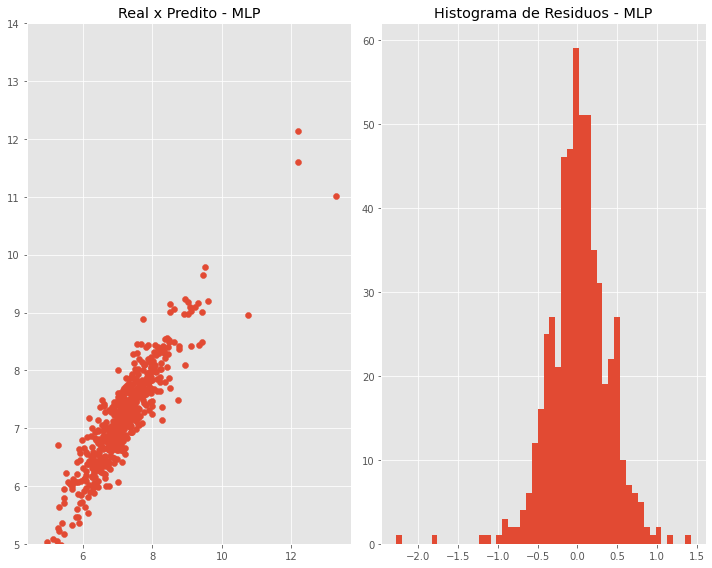

In [ ]:
if __name__ == "__main__":
    random.seed(42)
    # Base de Dados Crua
    df = pd.read_excel('dados_artigo_2 - cópia.xlsx', index_col=0).dropna()
    #print(df.head())

    # Base de Dados adaptada para um problema de aprendizado supervisionado
    df_sup = series_to_supervised(df, 6) # 6 Periodos de 4h = 24h
    #print(df_sup)

    # Características selecionadas no artigo para dados de entrada
    feat_selected = ['CEG_(t-1)', 'Prod_PQ_(t-0)', 'Cfix_(t-0)',
                     'pos_dp_03_(t-0)', 'Temp_02_(t-0)', 'Temp_05_(t-0)',
                     'Pres_01_(t-0)', 'Pres_04_(t-0)', 'rpm_03_(t-0)',
                     'Alt_Cam_(t-5)', 'Pres_01_(t-5)','rpm_06_(t-5)']
    X = df_sup[feat_selected]
    y = df_sup['CEG_(t-0)']
    nas_teste = NAS(X, y)
    nas_teste.normaliza_reduz_treino_teste()
    # rodadas = 1000
#     ### Testes do SKlearn
#     print('----- Rodando o MLP SkLearn --------')
#     referencia = 1.0
#     arquitetura = []
#     start = datetime.datetime.now()
#     print(start)
#     for _ in nas_teste.search_space_sklearn(rodadas):
#         #print(_)
#         rmse = nas_teste.modelo_MLP_skl(_).rmse_mlp
#         #print(f'RMSE: {rmse:.2f} m^3/t')
#         if rmse < referencia:
#             referencia = rmse
#             arquitetura = _
#     end = datetime.datetime.now()
#     print(end)
#     print(f'Duração: {end - start} p/ {rodadas} rodadas')
#     print('\n')
#     print(f'Menor RMSE SkLearn: {referencia:.2f} m^3/t')
#     print(f'Com Arquitetura: {arquitetura}')

#     #### Testes do Keras
#     print('\n')
#     print('----- Rodando o MLP keras --------')    
#     referencia = 1.0
#     arquitetura = []
#     start = datetime.datetime.now()
#     print(start)
#     for _ in nas_teste.search_space_keras(rodadas):
#         #print(_)
#         rmse = nas_teste.modelo_MLP_Keras(_).rmse_mlp_keras
#         #print(f'RMSE Modelo MLP Keras: {rmse:.2f} m^3/t')
#         if rmse < referencia:
#             referencia = rmse
#             arquitetura = _
#     end = datetime.datetime.now()
#     print(end)
#     print(f'Duração: {end - start} p/ {rodadas} rodadas')
#     print('\n')
#     print(f'Menor RMSE MLP Keras: {referencia:.2f} m^3/t')
#     print(f'Com Arquitetura: {arquitetura}')

    # ### Testes do LSTM
    # print('\n')
    # print('----- Rodando o LSTM keras --------')    
    # referencia = 1.0
    # arquitetura = []
    # start = datetime.datetime.now()
    # print(start)
    # for _ in nas_teste.search_space_keras(1000):
    #     #print(_)
    #     rmse = nas_teste.modelo_LSTM_Keras(_).rmse_mlp_lstm
    #     #print(f'RMSE Modelo LSTM Keras: {rmse:.2f} m^3/t')
    #     if rmse < referencia:
    #         print(_)
    #         print(f'RMSE Modelo LSTM Keras: {rmse:.2f} m^3/t')
    #         referencia = rmse
    #         arquitetura = _
    # end = datetime.datetime.now()
    # print(end)
    # print(f'Duração: {end - start} p/ {5} rodadas')
    # print('\n')
    # print(f'Menor RMSE LSTM Keras: {referencia:.2f} m^3/t')
    # print(f'Com Arquitetura: {arquitetura}')

    # #### Testes do Conv1d
    # print('\n')
    # print('----- Rodando o Conv1d --------')    
    # referencia = 1.0
    # arquitetura = []
    # start = datetime.datetime.now()
    # print(start)
    # for _ in nas_teste.search_space_keras(rodadas):
    #     #print(_)
    #     rmse = nas_teste.modelo_Conv_Keras(_).rmse_conv1d
    #     print(f'RMSE Modelo Conv1d: {rmse:.2f} m^3/t')
    #     if rmse < referencia:
    #         referencia = rmse
    #         arquitetura = _
    # end = datetime.datetime.now()
    # print(end)
    # print(f'Duração: {end - start} p/ {rodadas} rodadas')
    # print('\n')
    # print(f'Menor RMSE Conv1d: {referencia:.2f} m^3/t')
    # print(f'Com Arquitetura: {arquitetura}')

# Teste das Search Strategies
    aval = 100
    epocas = 5
    # start = datetime.datetime.now()
    # print(start)
    # print('\n')
    # print(' ---- MLP sklearn -----')
    # melhor_arquitetura = nas_teste.search_strategy_mlp_skl(aval, epocas).melhor_arch
    # print(melhor_arquitetura)
    # end = datetime.datetime.now()
    # print(end, sep='\n')
    # print('\n')
    # print(f'Duração: {end - start}')
    # print('-'* 40)
    # print(' ---- LSTM Keras -----')
    # start = datetime.datetime.now()
    # print(start)
    # nas_teste.search_strategy_mlp_keras(5, epocas)
    # end = datetime.datetime.now()
    # print(end, sep='\n')
    # print('\n')
    # print(f'Duração: {end - start}')
    # print('-'* 40)
    # print(' ---- Conv1d Keras -----')
    # start = datetime.datetime.now()
    # print(start)
    # nas_teste.search_strategy_mlp_keras(aval, epocas, modelo='CONV')
    # print('-'* 40)
    # end = datetime.datetime.now()
    # print(end, sep='\n')
    # print('\n')
    # print(f'Duração: {end - start}')

 #### Teste das Performance strategies
    nas_teste.performance_estimation_strategy(aval, epocas)
    print('\n')
    # nas_teste.performance_estimation_strategy(100, epocas, 'CONV')
    # print('\n')
    # nas_teste.performance_estimation_strategy(aval, epocas, 'LSTM')
    # for _ in range(5):
    #   start = datetime.datetime.now()
    #   print(start)
    #   print('\n')
    #   print(' ---- LSTM Keras -----')
    #   # nas_teste.performance_estimation_strategy(100, 5)
    #   nas_teste.performance_estimation_strategy(100, epocas, 'LSTM')
    #   end = datetime.datetime.now()
    #   print(end, sep='\n')
    #   print('\n')
    #   print(f'Duração: {end - start}')
    #   print('-'* 40)



In [ ]:
for _ in range(5):
    start = datetime.datetime.now()
    print(start)
    print('\n')
    print(' ---- MLP sklearn -----')
    nas_teste.performance_estimation_strategy(300, epocas) 
    end = datetime.datetime.now()
    print(end, sep='\n')
    print('\n')
    print(f'Duração: {end - start}')
    print('-'* 40)


2022-11-18 23:58:50.273001


 ---- MLP sklearn -----
Epoca: 1
[150, 'identity', 1e-08, 300, 0.001, 400]
RMSE: 0.535 m^3/t
[350, 'relu', 1e-06, 100, 0.001, 350]
RMSE: 0.471 m^3/t
[150, 'tanh', 1e-06, 50, 0.001, 350]
RMSE: 0.417 m^3/t
[200, 'tanh', 1e-08, 50, 0.001, 350]
RMSE: 0.410 m^3/t
[350, 'tanh', 1e-06, 300, 0.001, 350]
RMSE: 0.408 m^3/t
[350, 'tanh', 1e-06, 300, 0.001, 400]
RMSE: 0.401 m^3/t
----------------------------------------
Epoca: 2
[200, 'tanh', 1e-08, 50, 0.001, 350]
RMSE: 0.391 m^3/t
----------------------------------------
Epoca: 3
----------------------------------------
Epoca: 4
